# Joint Modeling Multi-omic Single-cell Datasets with **Cobolt**

In this tutorial, we illustrate the ability of Cobolt to integrate
multi-modality platforms with single-modality platforms by jointly analyzing the
following three datasets:
- A SNARE-seq dataset that jointly profiles gene expression and chromatin
accessibility in mouse cerebral cortex. The full dataset is available on Gene
Expression Omnibus (GEO) with accession number
[GSE126074](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126074).
- A single-cell gene expression dataset (scRNA-seq) of mouse primary motor
cortex (MOp), which is available on NeMO Archive with accession number
[nemo:dat-ch1nqb7](https://assets.nemoarchive.org/dat-ch1nqb7).
- A single-cell chromatin accessibility dataset (scATAC-seq) of mouse primary
motor cortex (MOp), which is available on NeMO Archive with accession number
[nemo:dat-ch1nqb7](https://assets.nemoarchive.org/dat-ch1nqb7).

The full datasets contain a total of more than 120,000 cells, which could take
one to two hours of running time depending on the GPU used. To
keep this vignette short and easy to run, we sampled a random subset of 2,000
cells from each of the above datasets. The subsampled dataset can be downloaded
[here](https://drive.google.com/drive/folders/1LvURxJ85DJkAcHgDsO4g_lujVDTZIpQv?usp=sharing).


In [1]:
from cobolt.utils import SingleData, MultiomicDataset
from cobolt.model import Cobolt
import os

In [2]:
# Path to the data directory
dat_dir = "../../example_data"

## Read Data

Read the SNARE-seq dataset that jointly profiles gene expression and chromatin
accessibility in mouse cerebral cortex. Here we read the data directly from
files. By default, the files for feature names, cell barcodes, and the count
matrix are __features.tsv__, __counts.mtx__, and __barcodes.tsv__.
Alternatively, a `SingleData` object can also be constructed using a processed
scipy sparse matrix of counts and string arrays of feature and barcode names.
Please refer to the documentation of `SingleData` for more details. Notice that
in order to recognize the joint cells, Cobolt requires the barcode and the
name of the dataset to be the same. Otherwise, cells will be treated as if
measured separately on single omics.

In [3]:
# Read the SNARE-seq gene expression data.
snare_mrna = SingleData.from_file(path=os.path.join(dat_dir, "snare"),
                                  dataset_name="SNARE-seq",
                                  feature_name="GeneExpr",
                                  count_file="gene_counts.mtx",
                                  feature_file="genes.tsv")

# Read the SNARE-seq chromatin accessibility data.
snare_atac = SingleData.from_file(path=os.path.join(dat_dir, "snare"),
                                  dataset_name="SNARE-seq",
                                  feature_name="ChromAccess",
                                  count_file="peak_counts.mtx",
                                  feature_file="peaks.tsv")

Next, we perform quality filtering on features, namely genes for gene expression
and peaks for chromatin accessibility. We filter out features that have total
counts smaller than its 70% quantile or higher than 99% quantile. We therefore
focus on the highly expressed features and remove the potential outlier
features. Filtering on barcode can be performed using function `filter_barcode`.
Cobolt is relatively robust to low-count cells and lowly-expressed features.
Here, we did not perform filtering on cells.

In [4]:
# Quality filtering on features.
snare_mrna.filter_features(upper_quantile=0.99, lower_quantile=0.7)
snare_atac.filter_features(upper_quantile=0.99, lower_quantile=0.7)

Read the gene expression dataset of mouse primary motor cortex and perform
quality filtering on genes.

In [5]:
mop_mrna = SingleData.from_file(path=os.path.join(dat_dir, "mrna"),
                                dataset_name="mRNA",
                                feature_name="GeneExpr",
                                feature_file="genes.tsv")
mop_mrna.filter_features(upper_quantile=0.99, lower_quantile=0.7)

Read the chromatin accessibility dataset of mouse primary motor cortex and
perform quality filtering on peaks.

In [6]:
mop_atac = SingleData.from_file(path=os.path.join(dat_dir, "atac"),
                                dataset_name="ATAC",
                                feature_name="ChromAccess",
                                feature_file="peaks.tsv")
mop_atac.filter_features(upper_quantile=0.99, lower_quantile=0.7)

Merge the above three datasets. Cells with the identical barcode names and
dataset names are recognized as joint cells. Cobolt focus on common features
shared across datasets. Genes are subset to those detected by both SNARE-seq
and scRNA-seq. We also performed preprocessing that mapped the SNARE-seq
chromatin accessibility counts to peaks called on the scATAC-seq dataset, such
that they share the same feature set. A batch variable is
automatically added when merging datasets. Different datasets are treated as
different batches.

In [7]:
multi_dt = MultiomicDataset.from_singledata(
    mop_mrna, mop_atac, snare_atac, snare_mrna)
print(multi_dt)

A MultiomicDataset object with 2 omics:
- GeneExpr: 7824 features, 4000 cells, 2 batches.
- ChromAccess: 41895 features, 4000 cells, 2 batches.
Joint cells:
- GeneExpr, ChromAccess: 2000 cells.


## Training

We now train the Cobolt model with the number of latent variables set to 10. We
use a small iteration in this vignette for illustration purpose. The default
number of iteration is set to 100.

In [8]:
model = Cobolt(dataset=multi_dt, lr=0.005, n_latent=10)
model.train(num_epochs=20)

100%|██████████| 20/20 [00:54<00:00,  2.71s/it]


Calculate the corrected latent variables.

In [9]:
model.calc_all_latent()

The latent variables can be accessed through function `get_all_latent`.

In [10]:
latent = model.get_all_latent()

The latent variables pre-correction can be accessed by setting the
`correction` parameter. The returned results contain all available posterior
means for each cell. For example, a SNARE-seq cell can have 3 posterior means,
corresponding to the posterior distribution given gene expression, given
chromatin accessibility, and given both modalities.

In [11]:
latent_raw = model.get_all_latent(correction=False)

## Clustering and Visualization

We can cluster cells on the latent variables using Leiden algorithm. Higher
resolution gives more clusters, and lower resolution gives fewer number of
clusters.

In [12]:
model.clustering(algo="leiden", resolution=0.5)

Users are encouraged to try different resolution parameters. Calls to
`clustering` function will be stored in the object. Cluster results obtained
with a specific algorithm and resolution and can be accessed as the following.

In [13]:
clusters = model.get_clusters(algo="leiden", resolution=0.5)

Visualize the clustering results on UMAP.

Running UMAP with latent variable correction.


/home/kinsley/projects/cobolt_pkg/cobolt/cobolt/model/cobolt.py:328: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


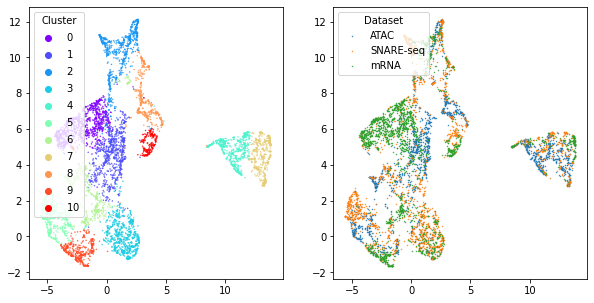

In [14]:
model.scatter_plot(reduc="UMAP", algo="leiden", resolution=0.5, s=0.2)

Access the UMAP reduced dimensions.

In [15]:
umap_reduc = model.reduction["UMAP2"]["embedding"]
